In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
import numpy as np
import re
import os
import time
import datetime
import gc
from random import random
import sklearn

In [ ]:
import nltk
import tensorflow as tf
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

class VocabularyProcessor:
    def __init__(self, max_document_length=None, min_frequency=0):
        self.max_document_length = max_document_length
        self.min_frequency = min_frequency
        self.vocab_dict = {}
        self.vocab_list = []
        self.reverse_vocab_dict = {}
        self.stop_words = set(stopwords.words('english') + list(punctuation))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, documents):
        # Convert all text to lowercase
        documents = [doc.lower() for doc in documents]
        
        # Tokenize the text
        documents = [nltk.word_tokenize(doc) for doc in documents]
        
        # Remove stop words
        documents = [[word for word in doc if word not in self.stop_words] for doc in documents]
        
        # Lemmatize the text
        documents = [[self.lemmatizer.lemmatize(word) for word in doc] for doc in documents]
        
        # Remove rare words
        if self.min_frequency > 0:
            word_counts = {}
            for doc in documents:
                for word in doc:
                    if word in word_counts:
                        word_counts[word] += 1
                    else:
                        word_counts[word] = 1
            
            documents = [[word for word in doc if word_counts[word] >= self.min_frequency] for doc in documents]
        
        # Create a vocabulary from the documents
        vocab = tf.keras.preprocessing.text.Tokenizer()
        vocab.fit_on_texts(documents)
        
        # Store the vocabulary for later use
        self.vocab_dict = {k: v-2 for k, v in vocab.word_index.items() if v is not None and (vocab.num_words is None or v <= vocab.num_words)}        
        self.vocab_list = sorted(self.vocab_dict, key=self.vocab_dict.get)
        self.reverse_vocab_dict = {v: k for k, v in self.vocab_dict.items()}

    def transform(self, documents):
        # Convert all text to lowercase
        documents = [doc.lower() for doc in documents]
        
        # Tokenize the text
        documents = [nltk.word_tokenize(doc) for doc in documents]
        
        # Remove stop words
        documents = [[word for word in doc if word not in self.stop_words] for doc in documents]
        
        # Lemmatize the text
        documents = [[self.lemmatizer.lemmatize(word) for word in doc] for doc in documents]
        
        # Map words to their ids in the vocabulary
        documents = [[self.vocab_dict.get(word, 0) for word in doc] for doc in documents]
        
        # Pad or truncate sentences to have a consistent length
        if self.max_document_length is not None:
            documents = tf.keras.preprocessing.sequence.pad_sequences(documents, maxlen=self.max_document_length, padding='post', truncating='post', value=0)
        
        return documents.tolist()

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)


In [ ]:
def get_train(filepath): # a simple function to divide sentences and the similarity 
    print("Loading training data from "+filepath)
    x1=[]
    x2=[]
    y=[]
    # positive samples from file
    for line in open(filepath):
        l=line.strip().split("\t")
        if len(l)<2:
            continue
        if random() > 0.5:
            x1.append(l[0].lower())
            x2.append(l[1].lower())
        else:
            x1.append(l[1].lower())
            x2.append(l[0].lower())
        y.append(int(l[2]))
    return np.asarray(x1),np.asarray(x2),np.asarray(y)

In [ ]:
def dumpValidation(x1_text,x2_text,y,shuffled_index,val_idx,i): #leaving out some sentences to test later 
    print("dumping validation "+str(i))
    x1_shuffled=x1_text[shuffled_index]
    x2_shuffled=x2_text[shuffled_index]
    y_shuffled=y[shuffled_index]
    x1_val=x1_shuffled[val_idx:]
    x2_val=x2_shuffled[val_idx:]
    y_val=y_shuffled[val_idx:]
    del x1_shuffled
    del y_shuffled
    with open('validation.txt'+str(i),'w') as f:
        for text1,text2,label in zip(x1_val,x2_val,y_val):
            f.write(str(label)+"\t"+text1+"\t"+text2+"\n")
        f.close()
    del x1_val
    del y_val

In [ ]:
def getDataSets(training_paths, max_document_length, percent_val, batch_size): #pour organiser mes donneesss

    x1_text, x2_text, y= get_train(training_paths) # Splitting parts of each line in our data
    # Build vocabulary
    print("Building vocabulary")
    
    
    vocab_processor = VocabularyProcessor(max_document_length) 
    vocab_processor.fit_transform(np.concatenate((x1_text,x2_text),axis=0))
    
    
    print("Length of loaded vocabulary ={}".format(len(vocab_processor.vocab_list))) # Get the vocab size
    
    
    train_set=[]
    val_set=[]
    
    sum_no_of_batches = 0
    
    x1 = np.asarray(list(vocab_processor.transform(x1_text)))
    x2 = np.asarray(list(vocab_processor.transform(x2_text)))
    
    
    # Randomly shuffle data
    np.random.seed(131)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x1_shuffled = x1[shuffle_indices]
    x2_shuffled = x2[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    val_idx = -1*len(y_shuffled)*percent_val//100
    del x1
    del x2
    
    
    # Saving for validation thingies
    dumpValidation(x1_text,x2_text,y,shuffle_indices,val_idx,0)
    
    
    # Getting random samples for each column
    x1_train, x1_val = x1_shuffled[:val_idx], x1_shuffled[val_idx:]
    x2_train, x2_val = x2_shuffled[:val_idx], x2_shuffled[val_idx:]
    y_train, y_val = y_shuffled[:val_idx], y_shuffled[val_idx:]
    print("Train/val split for {}: {:d}/{:d}".format(training_paths, len(y_train), len(y_val)))
    
    sum_no_of_batches = sum_no_of_batches+(len(y_train)//batch_size)
    
    train_set=(x1_train,x2_train,y_train)
    val_set=(x1_val,x2_val,y_val)
    
    gc.collect()
    return train_set,val_set,vocab_processor,sum_no_of_batches

In [ ]:
#Function to get max_doc_length 
def longest_sentence_length(sentences):

    max_length = 0
    for sentence in sentences:
        length = len(sentence.split())
        if length > max_length:
            max_length = length
    return max_length


In [35]:
training_files= "train_snli.txt"     #for sentence semantic similarity 
max_document_length=25  #should be 78--longest sentence
batch_size= 32    


In [36]:
x1_text, x2_text, y= get_train(training_files)

Loading training data from train_snli.txt


In [37]:
max(longest_sentence_length(x2_text),longest_sentence_length(x2_text))

78

In [38]:
train_set, val_set, vocab_processor,sum_no_of_batches = getDataSets(training_files,max_document_length, 10, batch_size)
vocab_size = len(vocab_processor.vocab_list)

Loading training data from train_snli.txt
Building vocabulary
Length of loaded vocabulary =26687
dumping validation 0
Train/val split for train_snli.txt: 330635/36738


In [39]:
import numpy as np


embedding_dim= 300 #Dimensionality of character embedding 
l2_reg_lambda= 0.0   # "L2 regularizaion lambda 
hidden_units= 256    #"Number of hidden units 

# Training parameters
learning_rate =1e-3

train_x1, train_x2, train_y = train_set
val_x1, val_x2, val_y = val_set

epochs = 500
batch_size = 32

# Now i prepare optimizers with a clip to avoid exploading gradients 
from tensorflow.keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm = 1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
sgd = SGD(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm, learning_rate = learning_rate)
adagrad = Adagrad(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
adam = Adam(clipnorm=gradient_clipping_norm, learning_rate = learning_rate)
adamax = Adamax(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
nadam = Nadam(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)


In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Subtract, Lambda, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


class Network(tf.keras.Model):
    
    def __init__(
        self, sequence_length, vocab_size, embedding_size, hidden_units, l2_reg_lambda, batch_size, train_set, dropout_rate, optimizer):
        
        super(Network, self).__init__()

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.l2_reg_lambda = l2_reg_lambda
        self.batch_size = batch_size
        self.train_set = train_set
        self.dropout_rate = dropout_rate

        
        
        self.input_x1 = Input(shape=(None, ), name="input_x1")
        self.input_x2 = Input(shape=(None, ), name="input_x2")

        # Network 1
        self.embedding_layer1 = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.sequence_length)
        self.embedded_x1 = self.embedding_layer1(self.input_x1)
        self.lstm_layer1 = LSTM(units=self.hidden_units, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg_lambda))
        self.encoded_x1 = self.lstm_layer1(self.embedded_x1)
        self.dropout_x1 = Dropout(rate=self.dropout_rate)(self.encoded_x1)

        # Network 2
        self.embedding_layer2 = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.sequence_length)
        self.embedded_x2 = self.embedding_layer2(self.input_x2)
        self.lstm_layer2 = LSTM(units=self.hidden_units, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg_lambda))
        self.encoded_x2 = self.lstm_layer2(self.embedded_x2)
        self.dropout_x2 = Dropout(rate=self.dropout_rate)(self.encoded_x2)

        # Compute Manh distance between encoded representations
        self.distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([self.dropout_x1, self.dropout_x2])

        # Add BatchNormalization layer
        self.bn_layer = BatchNormalization()
        self.distance = self.bn_layer(self.distance)

        
        # Define the output layer
        self.output_layer = Dense(units=1, activation="sigmoid", name="output")(self.distance)
        
        # Define the model and compile it
        self.model = Model(inputs=[self.input_x1, self.input_x2], outputs=self.output_layer)
        self.optimizer = optimizer
        
        # Compute class weights to handle class imbalance in training data
        self.model.compile(optimizer=self.optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy())


In [41]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Subtract, Lambda, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


class SiameseLSTM1(tf.keras.Model):
    
    def __init__(
        self, sequence_length, vocab_size, embedding_size, hidden_units, l2_reg_lambda, batch_size, train_set, dropout_rate, optimizer):
        
        super(SiameseLSTM1, self).__init__()

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.l2_reg_lambda = l2_reg_lambda
        self.batch_size = batch_size
        self.train_set = train_set
        self.dropout_rate = dropout_rate
    
        self.input_x1 = Input(shape=(None, ), name="input_x1")
        self.input_x2 = Input(shape=(None, ), name="input_x2")
        
        # Define the embedding layer
        self.embedding_layer = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.sequence_length)
        
        # Apply embedding layer to input sequences
        self.embedded_x1 = self.embedding_layer(self.input_x1)
        self.embedded_x2 = self.embedding_layer(self.input_x2)
        
        
        # Define the LSTM layer
        self.lstm_layer = GRU(units=self.hidden_units, return_sequences=False)
        
        # Apply LSTM layer to embedded input sequences
        self.encoded_x1 = self.lstm_layer(self.embedded_x1)
        self.encoded_x2 = self.lstm_layer(self.embedded_x2)
        
        # Apply dropout layer
        self.dropout_layer = Dropout(rate=self.dropout_rate)
        self.dropout_x1 = self.dropout_layer(self.encoded_x1)
        self.dropout_x2 = self.dropout_layer(self.encoded_x2)
        
        # Compute Manhattan distance between encoded input sequences
        self.distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([self.dropout_x1, self.dropout_x2])
        
        # Add BatchNormalization layer
        self.bn_layer = BatchNormalization()
        self.distance = self.bn_layer(self.distance)
        
        # Add more hidden layers
        self.hidden_layer1 = Dense(units=32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg_lambda))(self.distance)
        self.hidden_layer2 = Dense(units=32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg_lambda))(self.hidden_layer1)
        
        # Define the output layer
        self.output_layer = Dense(units=2, activation="sigmoid", name="output")(self.hidden_layer2)
        
        # Define the model and compile it
        self.model = Model(inputs=[self.input_x1, self.input_x2], outputs=self.output_layer)
        self.optimizer = optimizer
        
        # Compute class weights to handle class imbalance in training data
        self.model.compile(optimizer=self.optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy())


In [42]:
# create model

siamese_lstm = Network(sequence_length= max_document_length, vocab_size = vocab_size, embedding_size = embedding_dim, hidden_units = hidden_units, l2_reg_lambda=l2_reg_lambda, batch_size=batch_size, train_set=train_set,dropout_rate=0.3, optimizer=rmsprop )


In [43]:
# train model
from keras.callbacks import CSVLogger, TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TerminateOnNaN

callbacks = [
    ModelCheckpoint(filepath='models/best_model_lstm.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10),
    CSVLogger('models n logs/training_lstm.log'),
    TensorBoard(log_dir='./logs_lstm'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),  
    TerminateOnNaN(),
]




with tf.device('/gpu:0'):

    history = siamese_lstm.model.fit(
            x=[train_x1, train_x2],
            y=train_y,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([val_x1, val_x2], val_y),
            callbacks=callbacks,
            shuffle =True
        )


Epoch 1/500
10333/10333 [==============================] - 270s 26ms/step - loss: 0.5890 - binary_accuracy: 0.6673 - val_loss: 0.5206 - val_binary_accuracy: 0.7234
Epoch 2/500
10333/10333 [==============================] - 262s 25ms/step - loss: 0.5054 - binary_accuracy: 0.7420 - val_loss: 0.4941 - val_binary_accuracy: 0.7584
Epoch 3/500
10333/10333 [==============================] - 286s 28ms/step - loss: 0.4791 - binary_accuracy: 0.7642 - val_loss: 0.4755 - val_binary_accuracy: 0.7669
Epoch 4/500
10333/10333 [==============================] - 305s 29ms/step - loss: 0.4610 - binary_accuracy: 0.7788 - val_loss: 0.4889 - val_binary_accuracy: 0.7656
Epoch 5/500
10333/10333 [==============================] - 271s 26ms/step - loss: 0.4453 - binary_accuracy: 0.7901 - val_loss: 0.4840 - val_binary_accuracy: 0.7733
Epoch 6/500
10333/10333 [==============================] - 265s 26ms/step - loss: 0.4326 - binary_accuracy: 0.7990 - val_loss: 0.4818 - val_binary_accuracy: 0.7765
Epoch 7/500
1033

In [44]:
siamese_lstm.model.save('models/SiamseseLSTM.h5')

In [45]:
def get_test(filepath, vocab_processor= vocab_processor): #Getting our test data
    print("Loading testing/labelled data from "+filepath +" and preparing it for prediction ")
    x1=[]
    x2=[]
    y=[]
    # positive samples from file
    for line in open(filepath):
        l=line.strip().split("\t")
        if len(l)<3: # Get only relevantly long sentences
            continue
        x1.append(l[1].lower())
        x2.append(l[2].lower())
        y.append(int(l[0])) 
        
                
    x1_test = np.asarray(list(vocab_processor.transform(x1)))
    x2_test = np.asarray(list(vocab_processor.transform(x2)))
    
    

    
    return x1_test,x2_test,np.asarray(y)  

In [46]:
x1, x2, test_y = get_test("validation.txt0")

Loading testing/labelled data from validation.txt0 and preparing it for prediction 


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def try_out_sentences(model):
    # make a prediction using your trained Siamese LSTM model
    prediction = model.predict([x1, x2])
    
    # we change dimension to evaluate our model when return sequences is true

    #predictions_2d = predictions.mean(axis=1)
    #predictions_1d = predictions_2d.flatten()
    
    #prediction = predictions_1d

    print(f"Prediction: {prediction}")
    threshold = 0.5
    y_pred_binary = np.where(prediction >= threshold, 1, 0)
    
    
    acc = accuracy_score(test_y, y_pred_binary)
    precision = precision_score(test_y, y_pred_binary)
    recall = recall_score(test_y, y_pred_binary)
    f1 = f1_score(test_y, y_pred_binary)

    print("Accuracy: ", acc)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", f1)

    
    return x1, x2, test_y

In [48]:
test_x1, test_x2, test_y = try_out_sentences(siamese_lstm.model)

Prediction: [[0.86599916]
 [0.7311801 ]
 [0.07417114]
 ...
 [0.77146435]
 [0.03643684]
 [0.07321347]]
Accuracy:  0.7788393489030432
Precision:  0.7350435265789961
Recall:  0.8685232806259233
F1-score:  0.7962280239761241


In [49]:
model = siamese_lstm.model

[[12739  5722]
 [ 2403 15874]]


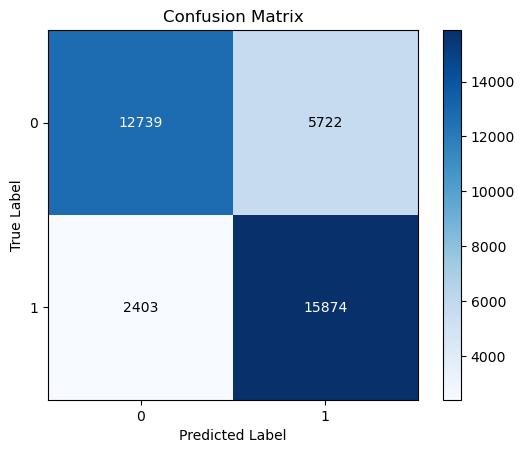

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on test data
y_pred = model.predict([test_x1, test_x2])

# Convert probabilities to class labels
y_pred = np.round(y_pred)

# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the plot
thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# Save the plot to the 'plots' folder
plt.savefig('plots/lstm/confusion_matrix_lstm.png')

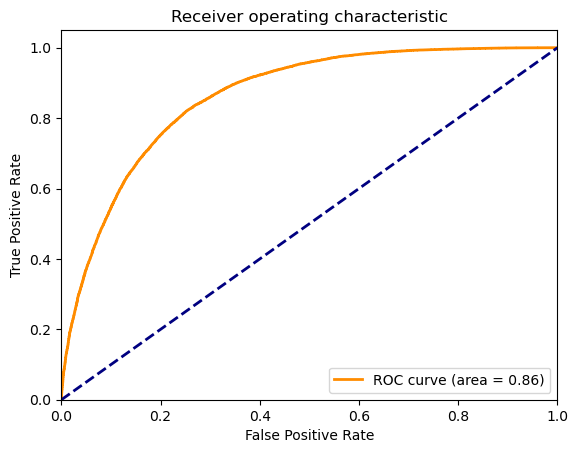

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Predict on test data
y_pred = model.predict([test_x1, test_x2])

# Compute fpr, tpr and auc
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('plots/lstm/ROC_curve_LSTM.png')
plt.show()


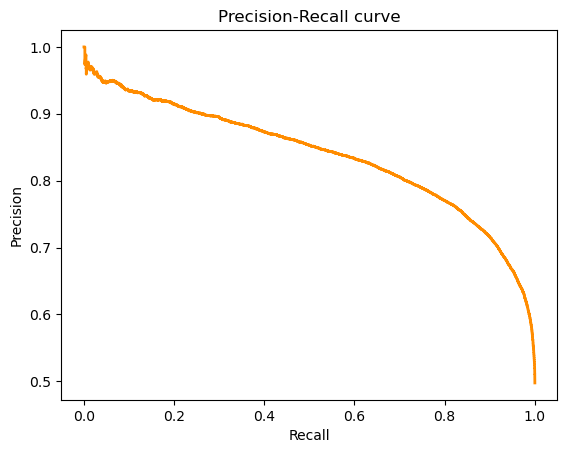

In [52]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt



# Predict on test data
y_pred = model.predict([test_x1, test_x2])

# Compute precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(test_y, y_pred)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.savefig('plots/lstm/Precision-Recall_curve_lstm.png')
plt.show()


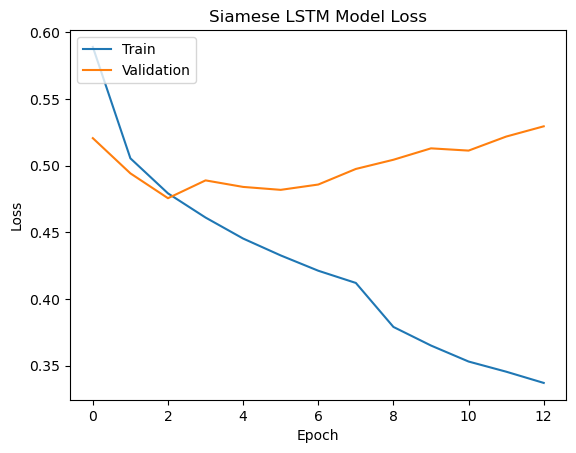

In [53]:
import matplotlib.pyplot as plt


# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Siamese LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('plots/lstm/loss_lstm.png')
plt.show()


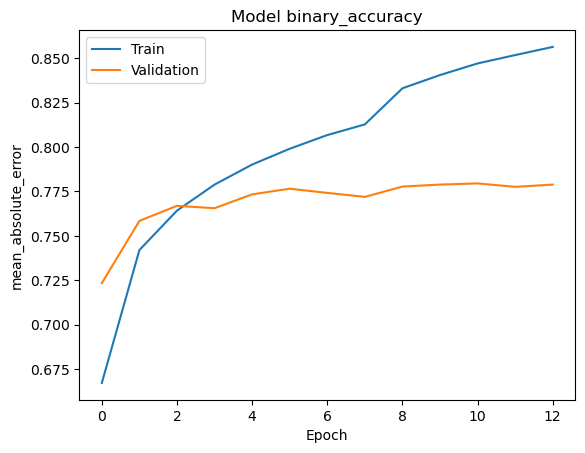

In [54]:
# Plot the accuracy
plt.figure()
plt.plot(history.history['binary_accuracy'], label='train_binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.title('Model binary_accuracy')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('plots/lstm/accs_lstm.png')
plt.show()